# Using Vector/Embedding DB to provide context to an LLM

<!-- HOW TO USE A VECTOR / EMBEDDING DATABASE TO PROVIDE CONTEXT TO A LARGE LANGUAGE MODEL -->

In this notebook we will see how to use an embedding database to store the information that we want to pass to a large language model so that it takes it into account in its responses.

The information could be our own documents, or whatever was contained in a business knowledge database.

I have prepared the notebook so that it can work with three different Kaggle datasets, so that it is easy to carry out different tests with different Datasets.

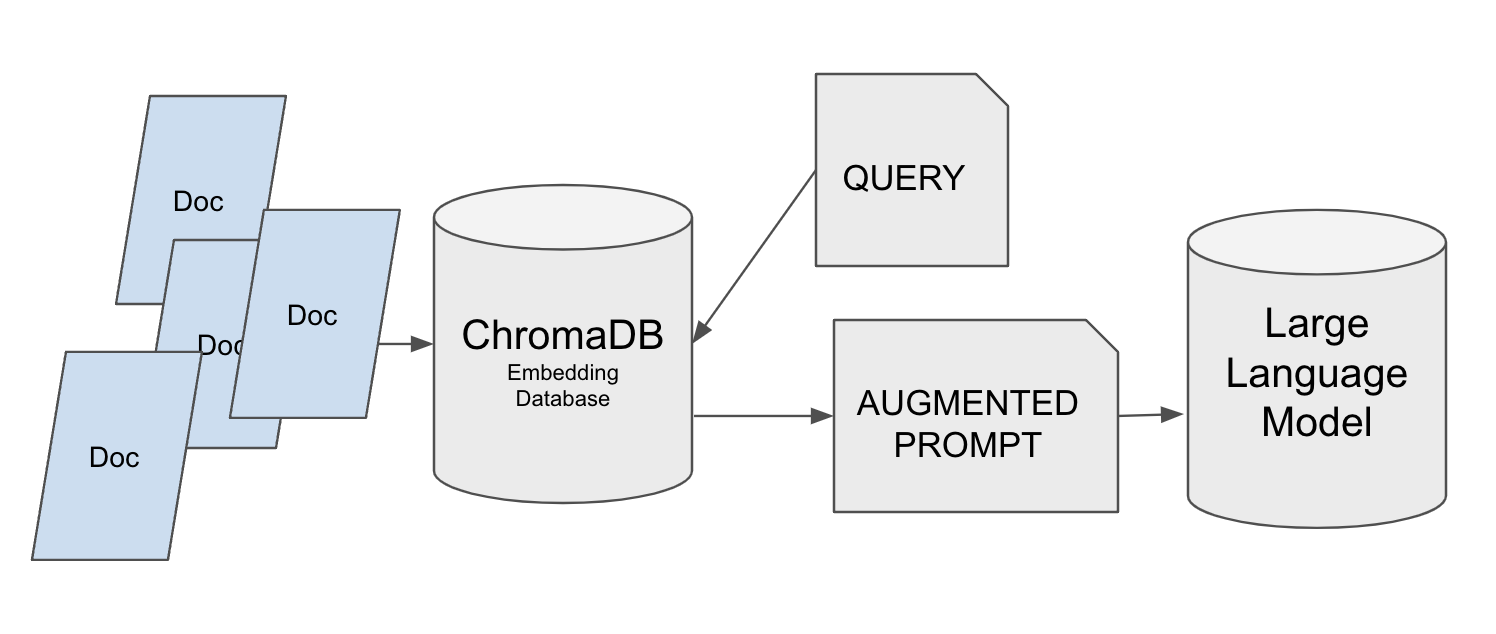

## Import and load the libraries

To start we need to install the necesary Python packages. 
* **[sentence transformers](http:/www.sbert.net/)**. This library is necessary to transform the sentences into fixed-length vectors, also know as embeddings. 
* **[xformers](https://github.com/facebookresearch/xformers)**. it's a package that provides libraries an utilities to facilitate the work with transformers models. We need to install in order to avoid an error when we work with the model and embeddings.  
* **[chromadb](https://www.trychroma.com/)**. This is our vector Database. ChromaDB is easy to use and open source, maybe the most used Vector Database used to store embeddings. 

In [5]:
# !pip install -q sentence-transformers==2.2.2
# !pip install -q xformers==0.0.23
# !pip install -q chromadb==0.4.20

I'm sure that you know the next two packages: Numpy and Pandas, maybe the most used python libraries.

Numpy is a powerful library for numerical computing. 

Pandas is a library for data manipulation

In [3]:
import numpy as np 
import pandas as pd

## Load the Dataset

As you can see the notebook is ready to work with three different Datasets. Just uncomment the lines of the Dataset you want to use. 

I selected Datasets with News. Two of them have just a brief decription of the new, but the other contains the full text. 

As we are working in a free and limited space, and we can use just 30 gb of memory I limited the number of news to use with the variable MAX_NEWS. 

The name of the field containing the text of the new is stored in the variable *DOCUMENT* and the metadata in *TOPIC*

In [4]:
news = pd.read_csv('/kaggle/input/topic-labeled-news-dataset/labelled_newscatcher_dataset.csv', sep=';')
MAX_NEWS = 1000
DOCUMENT="title"
TOPIC="topic"

#news = pd.read_csv('/kaggle/input/bbc-news/bbc_news.csv')
#MAX_NEWS = 1000
#DOCUMENT="description"
#TOPIC="title"

#news = pd.read_csv('/kaggle/input/mit-ai-news-published-till-2023/articles.csv')
#MAX_NEWS = 100
#DOCUMENT="Article Body"
#TOPIC="Article Header"


ChromaDB requires that the data has a unique identifier. We can make it with this statement, which will create a new column called **Id**.


In [5]:
news["id"] = news.index
news.head()

topic                                               link          domain  \
0  SCIENCE  https://www.eurekalert.org/pub_releases/2020-0...  eurekalert.org   
1  SCIENCE  https://www.pulse.ng/news/world/an-irresistibl...        pulse.ng   
2  SCIENCE  https://www.express.co.uk/news/science/1322607...   express.co.uk   
3  SCIENCE  https://www.ndtv.com/world-news/glaciers-could...        ndtv.com   
4  SCIENCE  https://www.thesun.ie/tech/5742187/perseid-met...       thesun.ie   

        published_date                                              title  \
0  2020-08-06 13:59:45  A closer look at water-splitting's solar fuel ...   
1  2020-08-12 15:14:19  An irresistible scent makes locusts swarm, stu...   
2  2020-08-13 21:01:00  Artificial intelligence warning: AI will know ...   
3  2020-08-03 22:18:26   Glaciers Could Have Sculpted Mars Valleys: Study   
4  2020-08-12 19:54:36  Perseid meteor shower 2020: What time and how ...   

  lang  id  
0   en   0  
1   en   1  
2   en   2  
3   en   3  
4   en   4

In [6]:
#Because it is just a course we select a small portion of News.
subset_news = news.head(MAX_NEWS)

## Import and configure the Vector Database

I'm going to use ChromaDB, the most popular OpenSource embedding Database. 

First we need to import ChromaDB, and after that import the **Settings** class from **chromadb.config** module. This class allows us to change the setting for the ChromaDB system, and customize its behavior. 

In [7]:
import chromadb
from chromadb.config import Settings

Now we need to create the seetings object calling the **Settings** function imported previously. We store the object in the variable **settings_chroma**.

Is necessary to inform two parameters 
* chroma_db_impl. Here we specify the database implementation and the format how store the data. I choose ***duckdb***, because his high-performace. It operate primarly in memory. And is fully compatible with SQL. The store format ***parquet*** is good for tabular data. With good compression rates and performance. 

* persist_directory: It just contains the directory where the data will be stored. Is possible work without a directory and the data will be stored in memory without persistece, but Kaggle dosn't support that. 

In [8]:
#OLD VERSION
#settings_chroma = Settings(chroma_db_impl="duckdb+parquet", 
#                          persist_directory='./input')
#chroma_client = chromadb.Client(settings_chroma)

#NEW VERSION => 0.40
chroma_client = chromadb.PersistentClient(path="/path/to/persist/directory")

## Filling and Querying the ChromaDB Database

The Data in ChromaDB is stored in collections. If the collection exist we need to delete it. 

In the next lines, we are creating the collection by calling the ***create_collection*** function in the ***chroma_client*** created above.

In [9]:
collection_name = "news_collection"
if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
        chroma_client.delete_collection(name=collection_name)

collection = chroma_client.create_collection(name=collection_name)
    

It's time to add the data to the collection. Using the function ***add*** we need to inform, at least ***documents***, ***metadatas*** and ***ids***. 
* In the **document** we store the big text, it's a different column in each Dataset. 
* In **metadatas**, we can informa a list of topics. 
* In **id** we need to inform an unique identificator for each row. It MUST be unique! I'm creating the ID using the range of MAX_NEWS. 


In [10]:

collection.add(
    documents=subset_news[DOCUMENT].tolist(),
    metadatas=[{TOPIC: topic} for topic in subset_news[TOPIC].tolist()],
    ids=[f"id{x}" for x in range(MAX_NEWS)],
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:04<00:00, 20.7MiB/s]


In [11]:
results = collection.query(query_texts=["laptop"], n_results=10 )

print(results)

{'ids': [['id173', 'id829', 'id117', 'id535', 'id141', 'id218', 'id390', 'id273', 'id56', 'id900']], 'distances': [[0.8593594431877136, 1.0294400453567505, 1.0793331861495972, 1.093001127243042, 1.1329681873321533, 1.2130440473556519, 1.214331865310669, 1.2164140939712524, 1.2220635414123535, 1.2754170894622803]], 'metadatas': [[{'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}, {'topic': 'TECHNOLOGY'}]], 'embeddings': None, 'documents': [['The Legendary Toshiba is Officially Done With Making Laptops', '3 gaming laptop deals you can’t afford to miss today', 'Lenovo and HP control half of the global laptop market', 'Asus ROG Zephyrus G14 gaming laptop announced in India', 'Acer Swift 3 featuring a 10th-generation Intel Ice Lake CPU, 2K screen, and more launched in India for INR 64999 (US$865)', "Apple's Next MacBook

## Vector MAP

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:

getado = collection.get(ids="id141", 
                       include=["documents", "embeddings"])


In [14]:
word_vectors = getado["embeddings"]
word_list = getado["documents"]
word_vectors

[[-0.0808560848236084,
  -0.049963705241680145,
  -0.023777484893798828,
  -0.011053602211177349,
  0.02665771171450615,
  -0.04479333013296127,
  -0.02889663353562355,
  0.026656104251742363,
  0.0014397227205336094,
  -0.016407841816544533,
  0.0653492733836174,
  -0.06901992857456207,
  -0.05748078227043152,
  0.010111615061759949,
  0.05043035000562668,
  -0.002057764446362853,
  0.07256408035755157,
  -0.12437368929386139,
  0.010659442283213139,
  -0.10942046344280243,
  -0.01143240462988615,
  -0.010376011952757835,
  -0.020610831677913666,
  -0.024394094944000244,
  0.07828476279973984,
  0.005820558872073889,
  0.023317726328969002,
  -0.08243829756975174,
  -0.02726505883038044,
  0.0046674772165715694,
  0.004340188577771187,
  0.03252805024385452,
  -0.026030974462628365,
  0.07963905483484268,
  0.042182061821222305,
  -0.12119994312524796,
  0.04907083883881569,
  -0.07625846564769745,
  0.04331624507904053,
  -0.08360457420349121,
  -0.07140401750802994,
  -0.01879251375

Once we have our information inside the Database we can query It, and ask for data that matches our needs. The search is done inside the content of the document, and it dosn't look for the exact word, or phrase. The results will be based on the similarity between the search terms and the content of documents. 

The metadata is not used in the search, but they can be utilized for filtering or refining the results after the initial search. 


## Loading the model and creating the prompt

TRANSFORMERS!!
Time to use the library **transformers**, the most famous library from [hugging face](https://huggingface.co/) for working with language models. 

We are importing: 
* **Autotokenizer**: It is a utility class for tokenizing text inputs that are compatible with various pre-trained language models.
* **AutoModelForCasualLLM**: it provides an interface to pre-trained language models specifically designed for language generation tasks using causal language modeling (e.g., GPT models), or the model used in this notebook ***databricks/dolly-v2-3b***.
* **pipeline**: provides a simple interface for performing various natural language processing (NLP) tasks, such as text generation (our case) or text classification. 

The model selected is [dolly-v2-3b](https://huggingface.co/databricks/dolly-v2-3b), the smallest Dolly model. It have 3billion paramaters, more than enough for our sample, and works much better than GPT2. 

Please, feel free to test [different Models](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending), you need to search for NLP models trained for text-generation. My recomendation is choose "small" models, or we will run out of memory in kaggle.  


In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "databricks/dolly-v2-3b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
lm_model = AutoModelForCausalLM.from_pretrained(model_id)



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


The next step is to initialize the pipeline using the objects created above. 

The model's response is limited to 256 tokens, for this project I'm not interested in a longer response, but it can easily be extended to whatever length you want.

Setting ***device_map*** to ***auto*** we are instructing the model to automaticaly select the most appropiate device: CPU or GPU for processing the text generation.  

In [16]:
pipe = pipeline(
    "text-generation",
    model=lm_model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    device_map="auto",
)

## Creating the extended prompt
To create the prompt we use the result from query the Vector Database  and the sentence introduced by the user. 

The prompt have two parts, the **relevant context** that is the information recovered from the database and the **user's question**. 

We only need to join the two parts together to create the prompt that we are going to send to the model. 

You can limit the lenght of the context passed to the model, because we can get some Memory problems with one of the datasets that contains a realy large text in the document part. 

In [17]:
question = "Can I buy a Toshiba laptop?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
#context = context[0:5120]
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"
prompt_template

"Relevant context: #The Legendary Toshiba is Officially Done With Making Laptops #3 gaming laptop deals you can’t afford to miss today #Lenovo and HP control half of the global laptop market #Asus ROG Zephyrus G14 gaming laptop announced in India #Acer Swift 3 featuring a 10th-generation Intel Ice Lake CPU, 2K screen, and more launched in India for INR 64999 (US$865) #Apple's Next MacBook Could Be the Cheapest in Company's History #Features of Huawei's Desktop Computer Revealed #Redmi to launch its first gaming laptop on August 14: Here are all the details #Toshiba shuts the lid on laptops after 35 years #This is the cheapest Windows PC by a mile and it even has a spare SSD slot\n\n The user's question: Can I buy a Toshiba laptop?"

Now all that remains is to send the prompt to the model and wait for its response!


In [18]:
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Relevant context: #The Legendary Toshiba is Officially Done With Making Laptops #3 gaming laptop deals you can’t afford to miss today #Lenovo and HP control half of the global laptop market #Asus ROG Zephyrus G14 gaming laptop announced in India #Acer Swift 3 featuring a 10th-generation Intel Ice Lake CPU, 2K screen, and more launched in India for INR 64999 (US$865) #Apple's Next MacBook Could Be the Cheapest in Company's History #Features of Huawei's Desktop Computer Revealed #Redmi to launch its first gaming laptop on August 14: Here are all the details #Toshiba shuts the lid on laptops after 35 years #This is the cheapest Windows PC by a mile and it even has a spare SSD slot

 The user's question: Can I buy a Toshiba laptop?
The answer: No, Toshiba has decided to stop manufacturing laptops.




## Summary
A very short notebook, but with a lot of content.

We have used a vector database to store information. Then move on to retrieve it and use it to create an extended prompt that we've used to call one of the newer large language models available in Hugging Face.

The model has returned a response to us taking into account the context that we have passed to it in the prompt.

This way of working with language models is very powerful.

We can make the model use our information without the need for Fine Tuning. This technique really has some very big advantages over fine tuning.

Please don't stop here.

* The notebook is prepared to use two more Datasets. Do tests with it.

* Find another model on Hugging Face and compare it.

* Modify the way to create the prompt.